<a href="https://colab.research.google.com/github/Nishan-Charlie/Her2_Histopathology/blob/main/Resnet_IHC_binary_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,regularizers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import f1_score
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.model_selection import train_test_split


import shutil
import random
from tensorflow.keras.metrics import AUC
import glob
import warnings
warnings.simplefilter(action='ignore', category = FutureWarning)
%matplotlib inline

In [ ]:
base  ="/content/drive/MyDrive/Colab Notebooks/FYP/Her2 - 2classesv02"

In [ ]:
# Initialising training and test paths
train_path = os.path.join(base, 'Train')
test_path =  os.path.join(base, 'Test')

# Classes
classes = os.listdir(train_path)
print(classes)

['Neg', 'Pos']


In [ ]:
# Function to count images in each class
def count_images(path):
    classes = os.listdir(path)
    class_counts = {}
    for cls in classes:
        class_dir = os.path.join(path, cls)
        if os.path.isdir(class_dir):
            num_images = len([name for name in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, name))])
            class_counts[cls] = num_images
    return class_counts

# Counting images in training and test sets
train_counts = count_images(train_path)
test_counts = count_images(test_path)

# Printing the results
print("Number of images in training set:")
for cls, count in train_counts.items():
    print(f"{cls}: {count}")

print("\nNumber of images in test set:")
for cls, count in test_counts.items():
    print(f"{cls}: {count}")

Number of images in training set:
Neg: 976
Pos: 630

Number of images in test set:
Neg: 145
Pos: 95


In [ ]:
dataGenerator = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input, validation_split=0.6,
    rotation_range=180,      # Randomly rotate images up to 40 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally by up to 20% of the width
    height_shift_range=0.2, # Randomly shift images vertically by up to 20% of the height
    shear_range=0.2,        # Apply shear transformations
    horizontal_flip=True,   # Randomly flip images horizontally
    )


train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input, rotation_range=180,
    width_shift_range=0.2,  # Randomly shift images horizontally by up to 20% of the width
    height_shift_range=0.2, # Randomly shift images vertically by up to 20% of the height
    shear_range=0.2,        # Apply shear transformations
    horizontal_flip=True).flow_from_directory(directory=train_path, target_size=(224, 224), classes=classes, batch_size=32,class_mode='categorical')


valid_batches = dataGenerator.flow_from_directory(directory= test_path, target_size = (224,224),classes = classes, batch_size = 16,class_mode='categorical',subset='validation')

test_batches = dataGenerator.flow_from_directory(directory = test_path, target_size=(224,224),classes = classes, batch_size = 16, shuffle = False,class_mode='categorical',subset='training')


Found 1606 images belonging to 2 classes.
Found 144 images belonging to 2 classes.
Found 96 images belonging to 2 classes.


In [ ]:
# Function for ploting the confusion matrix
def plot_confusion_matrix(cm, classes, normalize= False, title='Confusin Matrix', cmap = plt.cm.Blues):
  plt.imshow(cm, interpolation = 'nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation = 45)
  plt.yticks(tick_marks,classes)

  if normalize:
    cm = cm.astype('flot')/ cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print("Confusion matrix, without normalization")

  thresh = cm.max()/2
  for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i,cm[i,j],
             horizontalalignment = "center",
             color="white" if cm[i,j]> thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# Instantiate the ResNet50 base model
resnet50_base = ResNet50(include_top=False, input_shape=(224, 224, 3), weights='imagenet')

resnet50_base.summary()

model = Sequential()
model.add(resnet50_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='sigmoid'))


Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_7[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [ ]:
for layer in resnet50_base.layers[:40]:
   layer.trainable = False

print('conv_base is now NOT trainable')

conv_base is now NOT trainable


In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_6 (Flatten)         (None, 100352)            0         
                                                                 
 dropout_11 (Dropout)        (None, 100352)            0         
                                                                 
 dense_10 (Dense)            (None, 64)                6422592   
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 2)                 130       
                                                                 
Total params: 30010434 (114.48 MB)
Trainable params: 2

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
model.compile(optimizer = Adam(learning_rate = 0.0001), loss='categorical_crossentropy', metrics=['accuracy', f1_m])

In [ ]:
train_batches.class_indices

{'Neg': 0, 'Pos': 1}

In [ ]:
history = model.fit(x= train_batches, validation_data = valid_batches, epochs = 25)

Epoch 1/25
51/51 [==============================] - 164s 2s/step - loss: 0.6965 - accuracy: 0.8667 - f1_m: 0.8002 - val_loss: 0.3395 - val_accuracy: 0.9236 - val_f1_m: 0.8437
Epoch 2/25
51/51 [==============================] - 46s 898ms/step - loss: 0.2971 - accuracy: 0.9408 - f1_m: 0.8382 - val_loss: 0.2580 - val_accuracy: 0.9444 - val_f1_m: 0.8655
Epoch 3/25
51/51 [==============================] - 46s 897ms/step - loss: 0.2468 - accuracy: 0.9558 - f1_m: 0.8465 - val_loss: 0.1786 - val_accuracy: 0.9722 - val_f1_m: 0.9474
Epoch 4/25
51/51 [==============================] - 47s 916ms/step - loss: 0.2534 - accuracy: 0.9645 - f1_m: 0.8537 - val_loss: 0.1887 - val_accuracy: 0.9792 - val_f1_m: 0.8907
Epoch 5/25
51/51 [==============================] - 47s 923ms/step - loss: 0.2083 - accuracy: 0.9633 - f1_m: 0.8068 - val_loss: 0.1707 - val_accuracy: 0.9792 - val_f1_m: 0.9274
Epoch 6/25
51/51 [==============================] - 45s 901ms/step - loss: 0.1887 - accuracy: 0.9670 - f1_m: 0.8023 -

In [ ]:
model_folder = "/content/drive/MyDrive/Medical Imaging/Model folder"
model.save(model_folder+"/iHC_Binary_resnet_50.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import json

history_dict = history.history

file_path = os.path.join(model_folder, 'resnet_IHC_binary_history.json')
with open(file_path, 'w') as f:
    json.dump(history_dict, f)


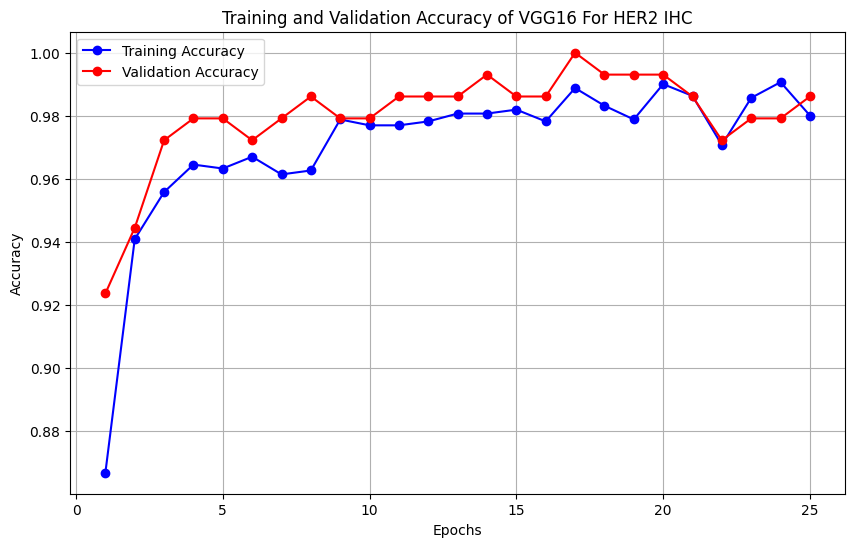

In [ ]:
# Extract training and validation accuracy
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Create a range of epochs
epochs = range(1, 26)

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy of VGG16 For HER2 IHC')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

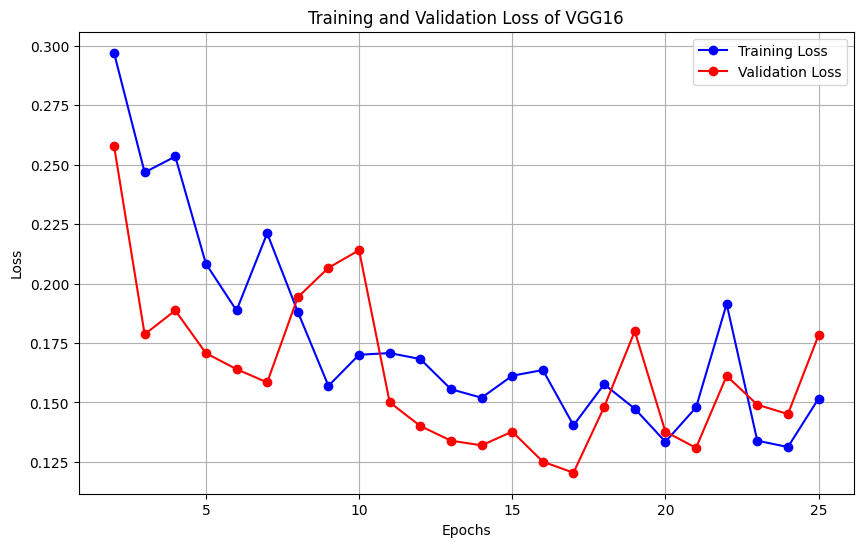

In [ ]:
# Extract training and validation accuracy
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Create a range of epochs
epochs = range(2, 26)

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss[1:], 'bo-', label='Training Loss')
plt.plot(epochs, validation_loss[1:], 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss of VGG16')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
test_loss, test_accuracy ,f1_score= model.evaluate(test_batches)
print("Testing Loss:", test_loss)
#print("AUC", AUC)
print("Testing Accuracy:", test_accuracy)

6/6 [==============================] - 29s 6s/step - loss: 0.1083 - accuracy: 1.0000 - f1_m: 1.0000
Testing Loss: 0.10826632380485535
Testing Accuracy: 1.0


6/6 [==============================] - 4s 559ms/step


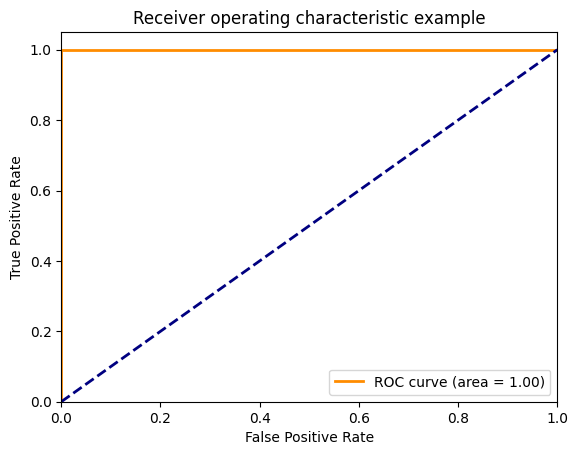

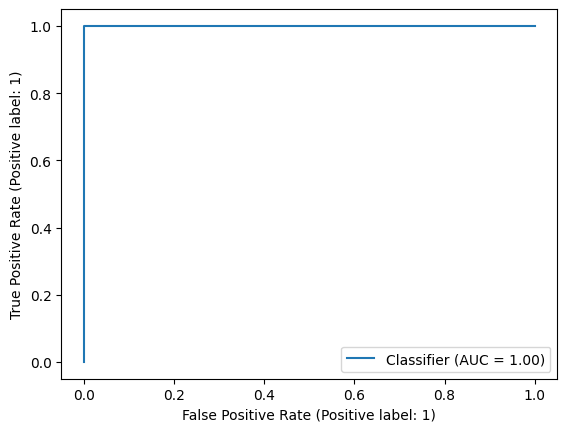

In [ ]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

# Get predictions
y_pred = model.predict(test_batches)

# Get true labels
y_true = test_batches.labels

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Display ROC curve using sklearn
RocCurveDisplay.from_predictions(y_true, y_pred[:, 1])
plt.show()


6/6 [==============================] - 2s 346ms/step
Confusion matrix, without normalization


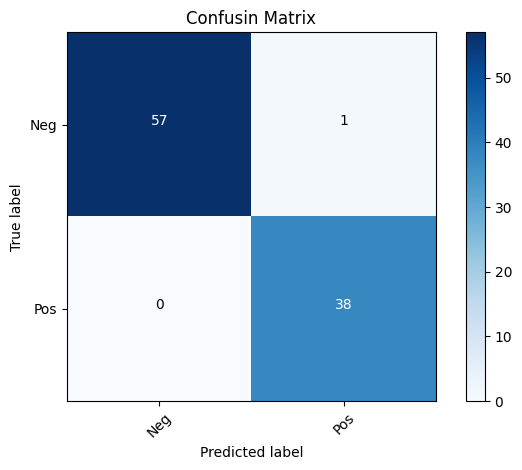

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

# Get predictions
y_pred = model.predict(test_batches)

# Get true labels
y_true = test_batches.labels

# Calculate confusion matrix
cm = confusion_matrix(y_true, np.argmax(y_pred, axis=1))

# Plot confusion matrix
plot_confusion_matrix(cm, classes=classes)


#SHAP
